![](https://upload.wikimedia.org/wikipedia/commons/3/38/Forest_panorama_2.jpg "Machine learning from woods - exploring tree-based ensemble models")

# Machine learning from woods - exploring tree-based ensemble models

### Intro

Ensemble models are definitely a hot topic in machine learning area. They win a lot of data science competitions (ex. organized by Kaggle or DrivenData), they are relatively easy to understand (at least some of them) and they usually doesn’t require large clusters of GPU-accelerated machines to give some reasonable results. Therefore ensemble models definitely deserve being in arsenal of anyone who deals with machine learning problems.

In this blogpost, I will present some basic theory behind three ensemble models: random forest, AdaBoost and gradient tree boosting. Then, we will see how to implement them using one of the most popular machine learning library: Scikit-Learn and how to improve their out-of-the-box performance. You definitely don’t have to be a machine learning expert or statistical/mathematical genius to understand this text, but it will be easier if you are familiar with some main ideas of supervised learning.

### ML Background

Let’s start by briefly introducing two crucial concepts to understand this section, namely: bias and variance. These two describes dependency between model complexity and data. When bias is high it means that model is too general and ignores many important patterns. On the other hand high variance appears when model “focuses” on gentle details too much, losing broader view on data. Finding optimal model is always a trade-off between bias and variance.

In the next sections we will solve classification problems on several datasets. Classification models learn patterns from features that characterize each class, so later given only features of new sample, they can output it’s class label.

General idea behind ensemble models is so simple, that [even pigeons could understand it](https://www.theguardian.com/society/2015/nov/19/pigeons-can-identify-cancerous-tissue-on-x-rays-study-finds). Here’s a recipe: get a set of models, aggregate their predictions and you are ready to go! There are of course many tricks to draw best results from ensembles and we’ll discover some of them later, but for now this intuition is sufficient. There is still one evidently unclear thing: why the title is so “woody”, and what does it mean that models are tree-based? It turns out that most commonly used algorithms to combine into ensembles are decision trees. So before diving into how random forest, AdaBoost and gradient tree boosting works, let’s focus on it’s building blocks. 

#### Decision Trees

To put it simply, decision trees are models that are build on set of boolean conditions defined on features of data, that are composed in tree form. Using given [criterions](http://scikit-learn.org/stable/modules/tree.html#classification-criteria) they find most optimal decision boundaries. One of their advantage is fact, that they are easy to visualize, so let’s do it to clarify how these boundaries interact with each other.

Let’s create simple dataset, where each of 100 samples is defined by only two features (dimensions): X and Y, and there are three classes: “red”, “green” and “blue” using `make_blobs` function from Scikit-Learn library:

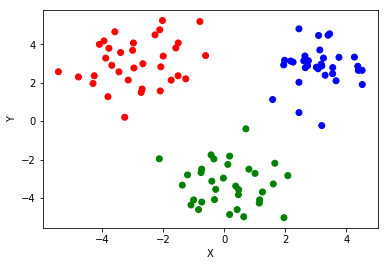

In [1]:
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs

%matplotlib inline

RANDOM_STATE = 123  # Ensure repeatability when using randomness
COLORS = ["red", "green", "blue"]
FEATURES_NAMES = ["X", "Y"]

features, labels = make_blobs(centers=[(-3, 3), (0, -3), (3, 3)], random_state=RANDOM_STATE)
labels_colors = [COLORS[label] for label in labels]

plt.scatter(features[:, 0], features[:, 1], c=labels_colors)
plt.xlabel(FEATURES_NAMES[0])
plt.ylabel(FEATURES_NAMES[1])
plt.show()

Then we can create our tree classifier. All Scikit-Learn's share the same API for training: method `fit(features, labels)`.

In [2]:
import sklearn.tree

decision_tree = sklearn.tree.DecisionTreeClassifier()
decision_tree.fit(features, labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Finally we will use graphviz library to investigate the structure of out tree classifier.

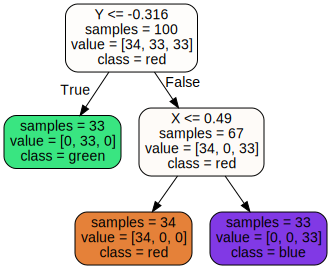

In [3]:
import graphviz

tree_data = sklearn.tree.export_graphviz(decision_tree,
                                         out_file=None,
                                         feature_names=FEATURES_NAMES,
                                         class_names=COLORS,
                                         rounded=True,
                                         filled=True,
                                         impurity=False)
tree_graph = graphviz.Source(tree_data)
tree_graph

First row in node describes decision boundary (not present in leafs), next is number of samples that falls into that node, another one is node’s samples distribution between classes, and the last one is most common class in the node, which in leafs is interpreted as tree output label.

As you can see, decision trees handled well this toy example, and in fact they handle well many real-life problems. Moreover they need very little data preprocessing: ex. scaling data is not needed, because trees will find decision boundaries independently of magnitude of given feature. In addition, decision trees can handle both numerical and categorical data. However they are very prone to overfitting - what means they easily become high-variance models. That results in instability, because small changes in training set can result in major decision boundaries shifts. There are many ways to handle this problem and the most successful one is using more than one tree to build ensemble classifier.

#### Random Forest

You may ask yourself, how using many high-variance models can in fact reduce variance and decrease general error? Let’s imagine you have several datasets, each representing the same phenomenon, but they are taken from different samples of population. If you train decision tree on one of this sets, you won’t have amazing overall performance, but if you will ask set of trees trained on different data to come to a consensus, individual variances will cancel out. But how to train decision trees, so that we have several different models using just one training dataset? That’s where idea of bagging is coming with rescue. Let’s say you have 1000 samples in your training set, and you want to create 25 new training sets to train 25 different decision trees. You just pick randomly 1000 samples (with replacement) from your training set (bag). In new training set, some samples from original one will appear more than once, and some won’t appear at all. If you repeat this procedure 25 times, you’ll have 25 different training sets for building your trees. To get final prediction of ensemble, you just pick the most common output of all trees. You may also use probabilities of classes instead of just labels. They can be taken from distribution of class representants in final tree node (leaf). Using this attitude, your model will favour more confident trees, which sounds reasonable.

But random forest is more than just bagging trees. To make individual trees even more diverse, you randomly limit set of features available when splitting a node. This way, each time when tree tries to find an optimal decision boundary, it “sees” only random subset of all features. This draw take place each time node is split. Common measure is to randomly take $\sqrt{n}$ or $\log_{2}{n}$ features to make a split wheren is original number of features.


#### AdaBoost

There is another family of ensembling methods called boosting, that tackles problem from the other side. This time we will use many weak learners (only slightly better than random guessing), that are high-bias models. Because every base model will be biased in different way, they will cancel out general bias.

Trees that build AdaBoost ensemble, are created sequentially in such a way that new tree should reduce error made by previous models. What is important, once tree is trained, it remains untouched during rest of ensemble training. Trees used in AdaBoost are really shallow, often having only 2 leafs (such trees are called decision stumps). Using trees as base learners is not required by AdaBoost algorithm, but it’s most common practice.

When creating AdaBoost model, all training samples has weights bounded to it. Initially all weights are the same and equal 1N, where N is number of samples. After one tree is trained, weights of wrongly classified samples are increased, and that modified version of dataset is an input to another tree from ensemble. This procedure continues until maximum number of trees is reached or adding new tree don’t result in reducing training error. Output prediction is combination of outputs from all shallow trees, weighted by each tree accuracy. If you are curious what formulas are used for weighting samples, as well as predictions, I highly recommend [blogpost from Jason Brownlee about AdaBoost](https://machinelearningmastery.com/boosting-and-adaboost-for-machine-learning/). 

#### Gradient Tree Boosting

Gradient tree boosting is next member of boosting algorithms family. Similarly to AdaBoost, it is built from set of small trees, but usually slightly deeper than decision stumps. Trees are trained sequentially, just like in AdaBoost, but training of individual trees is not the same.

Trees that are used in gradient tree boosting differ from trees that was described earlier. They are regression trees, so theirs aim is to produce some real value number for each sample. In fact, they are pretty similar to classification decision trees, but they put into leafs samples that have similar (ideally, the same) real values bounded to them. Output value from given leaf is mean value from all samples that get there during training. In case of gradient tree boosting, such trees are constructed for each class independently. They learn to output probability that given sample is a member of given class. Values bounded to samples are either 0 (member of another class) or 1 (member of this class), so perfect tree will output only 0 or 1 and flawed one will produce numbers between 0 and 1.

The main idea behind the algorithm is to iteratively find new trees that minimizes loss function: measure to tell how bad model is. It have to be differentiable, and it’s picked based on problem to solve. For classification it is usually log loss, that is just negative mean of log-probabilities that sample xi is classified as it’s label:
$$loss = -\frac{1}{N}\sum_{i=1}^{N}{\log{p(TRUE LABEL | x_i)}}$$
Having loss value, we can calculate so-called pseudo residuals, that are gradients (partial derivatives) of loss with respect to predictions from previous trees. Pseudo residuals are then plugged instead of labels (ones and zeros in fact) when training a new tree. It does make sense, because new tree will treat differently samples that were completely wrong classified by previous trees and the ones that were pretty close to correct prediction. In addition, trees are parameterized, and these parameters are also optimized during training in order to reduce loss. If you are hungry for more math that explains the whole process you may want to read [wikipedia article](https://en.wikipedia.org/wiki/Gradient_boosting#Algorithm), or [whitepaper](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf) from one of the fathers of this method.


### Dataset

To test our algorithms, we will use plain old dataset of Australian Credit Approval. Based on given features of customer (feature names was removed, but it's not important for us), our model will try to predict whether to accept or reject credit card application. There are only two classes: accepted and rejected, so this problem can be named as binary classification. This dataset is available [here](http://mldata.org/repository/data/viewslug/australian/), and we will use an utility Scikit-Learn's function `fetch_mldata` to easily download datasets from mldata.org. We also shuffle data and split it to train and test sets, so after training we can evaluate our model on previously unseen data.

In [7]:
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

DATASET_NAME = "australian"
TEST_SIZE = 0.2

data_bunch = fetch_mldata(DATASET_NAME)
features, labels = shuffle(data_bunch.data, data_bunch.target, random_state=RANDOM_STATE)
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE)

### Ensemble models in scikit-learn

### Results

### Model tuning

#### Hyperparameters

#### Cross-validation

### Summary